In [1]:
import os
os.chdir('../..')

In [2]:
from classes.matching import Matching

import numpy as np
import json
import pandas as pd
from datetime import datetime
import time

from classes.helpers import *

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

colors = {'ba': (232/255,164/255,29/255), 'rb': (0/255,152/255,205/255)}
labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

notext = {'ba': 'nan', 'rb': ''}

data_folder = '../data/'
save_folder = '../figures/all/3-standardization/'

# Compute yearly z-score

In [3]:
ratings_year = {'ba': {}, 'rb': {}}

for key in ratings_year.keys():
    print('Parsing {} reviews.'.format(key.upper()))
    
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    for item in gen:
        
        date = int(item['date'])
        year = datetime.fromtimestamp(date).year
                        
        if year not in ratings_year[key].keys():
            ratings_year[key][year] = []

        ratings_year[key][year].append(float(item['rating']))

Parsing BA reviews.
Parsing RB reviews.


In [4]:
z_score_params = {}
for key in ratings_year.keys():
    z_score_params[key] = {}
    for y in ratings_year[key].keys():
        z_score_params[key][y] = {'mean': np.mean(ratings_year[key][y]), 'std': np.std(ratings_year[key][y])}
        if z_score_params[key][y]['std'] == 0:
            z_score_params[key][y]['std'] = 1

In [5]:
z_score_params

{'ba': {1998: {'mean': 3.5414285714285714, 'std': 0.39306228410224436},
  1999: {'mean': 3.8199999999999998, 'std': 1},
  2000: {'mean': 4.1583333333333332, 'std': 0.34854060818727511},
  2001: {'mean': 3.9546788990825688, 'std': 0.72756167973006391},
  2002: {'mean': 3.8784154175588865, 'std': 0.60714628480635691},
  2003: {'mean': 3.7894457334364531, 'std': 0.60914985795998122},
  2004: {'mean': 3.8282890743550833, 'std': 0.57276238221581977},
  2005: {'mean': 3.80431905465288, 'std': 0.59223581958814531},
  2006: {'mean': 3.7975972062962575, 'std': 0.56910643506455871},
  2007: {'mean': 3.7664698588325072, 'std': 0.57135464656499546},
  2008: {'mean': 3.7865197971994204, 'std': 0.55619360273815999},
  2009: {'mean': 3.814592780044415, 'std': 0.54427965051782634},
  2010: {'mean': 3.7957496043457803, 'std': 0.5678871603994663},
  2011: {'mean': 3.8883646732429105, 'std': 0.6319186835115248},
  2012: {'mean': 3.8220877093386325, 'std': 0.6352226355048306},
  2013: {'mean': 3.866918664

In [7]:
z_score_params['ba'][1996] = {'mean': 0, 'std': 1}
z_score_params['ba'][1997] = {'mean': 0, 'std': 1}

In [8]:
with open(data_folder + 'tmp/z_score_params_matched_ratings.json', 'w') as file:
    json.dump(z_score_params, file)

# Add zscore to beers

In [21]:
with open('../data/tmp/z_score_params_matched_ratings.json') as file:
    z_score_params = json.load(file)

In [ ]:
beers_zscore = {}
for key in ['ba', 'rb']:
    
    beers_zscore[key] = {}
    
    print('Parse ratings from {}'.format(key.upper()))

    # Get the generator
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    for item in gen:
        beer_id = int(item['beer_id'])
        
        if beer_id not in beers_zscore[key].keys():
            beers_zscore[key][beer_id] = []
            
        rat = float(item['rating'])
            
        year = time.strftime('%Y', time.localtime(int(item['date'])))
        zscore = (rat-z_score_params[key][year]['mean'])/(z_score_params[key][year]['std'])
            
        beers_zscore[key][beer_id].append(zscore)

In [23]:
beers_avg_zscore = {}
for key in beers_zscore.keys():
    beers_avg_zscore[key] = {}
    for id_ in beers_zscore[key].keys():
        beers_avg_zscore[key][id_] = np.mean(beers_zscore[key][id_])

In [24]:
for key in ['ba', 'rb']:
    ratings = []
    
    df = pd.read_csv('../data/{}/beers.csv'.format(key))
    
    for i in df.index:
        row = df.iloc[i]
        
        beer_id = int(row['beer_id'])
        
        if beer_id not in beers_avg_zscore[key].keys():
            ratings.append(np.nan)
        else:
            ratings.append(beers_avg_zscore[key][beer_id])
                        
    df.loc[:, 'zscore'] = ratings
    
    df.to_csv('../data/{}/beers.csv'.format(key), index=False)

In [32]:
df = pd.read_csv('../data/matched/beers.csv', header=[0,1])

for key in ['ba', 'rb']:
    
    zscores = []
    for i in df.index:
        row = df.iloc[i][key]
        
        beer_id = int(row['beer_id'])
        
        if beer_id not in beers_avg_zscore[key].keys():
            zscores.append(np.nan)
        else:
            zscores.append(beers_avg_zscore[key][beer_id])
                        
    df.loc[:, (key, 'zscore')] = zscores

df.to_csv('../data/matched/beers.csv', index=False)

## Histogram of z-score 

In [9]:
zscore = {'ba': [], 'rb': []}

for key in ratings_year.keys():
    print('Parsing {} reviews.'.format(key.upper()))
    
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    for item in gen:
        
        date = int(item['date'])
        year = datetime.fromtimestamp(date).year
        
        rat = float(item['rating'])
                        
        zscore[key].append((rat-z_score_params[key][year]['mean'])/z_score_params[key][year]['std'])

Parsing BA reviews.
Parsing RB reviews.


In [10]:
print(min(np.min(zscore['ba']), np.min(zscore['rb'])))
print(max(np.max(zscore['ba']), np.max(zscore['rb'])))

-6.65570359179
2.94112297766


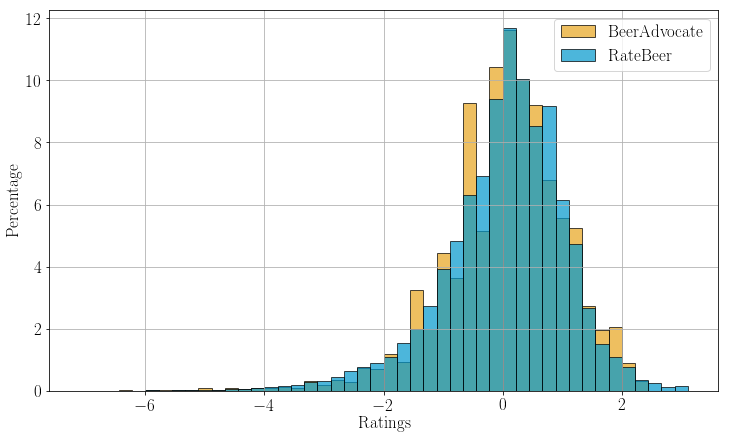

In [12]:
nbr_bins = 45

bin_edges = {'ba': None, 'rb': None}
hist = {'ba': None, 'rb': None}

for key in colors.keys():
    a, bin_edges[key] = np.histogram(zscore[key], range=(-7, 3), bins=nbr_bins)
    hist[key], a = np.histogram(zscore[key], range=(-7, 3), bins=nbr_bins+1)
    hist[key] = hist[key]/np.sum(hist[key])*100
    
plt.figure(figsize=(12,7))
plt.rc('font', family='serif')
plt.rc('font', size=17)

for key in hist.keys():
    width = bin_edges[key][1] - bin_edges[key][0]
    plt.bar(bin_edges[key], hist[key], width = width, facecolor=colors[key], edgecolor='k', alpha=0.7, label=labels[key])
    
plt.grid()
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Ratings')

plt.savefig(save_folder + 'zscore_matched_beers.pdf', bbox_inches='tight')

## On the average of the beers

In [13]:
zscore = {'ba': {}, 'rb': {}}

for key in zscore.keys():
    print('Parsing {} reviews.'.format(key.upper()))
    
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    for item in gen:
        
        date = int(item['date'])
        year = datetime.fromtimestamp(date).year
        
        beer_id = int(item['beer_id'])
        
        rat = float(item['rating'])
        
        if beer_id not in zscore[key].keys():
            zscore[key][beer_id] = []
            
        zscore[key][beer_id].append((rat-z_score_params[key][year]['mean'])/z_score_params[key][year]['std'])
        
zscore_avg = {'ba': [], 'rb': []}

for key in zscore_avg.keys():
    for id_ in zscore[key]:
        zscore_avg[key].append(np.mean(zscore[key][id_]))

Parsing BA reviews.
Parsing RB reviews.


In [14]:
print(min(np.min(zscore_avg['ba']), np.min(zscore_avg['rb'])))
print(max(np.max(zscore_avg['ba']), np.max(zscore_avg['rb'])))

-6.65570359179
2.94112297766


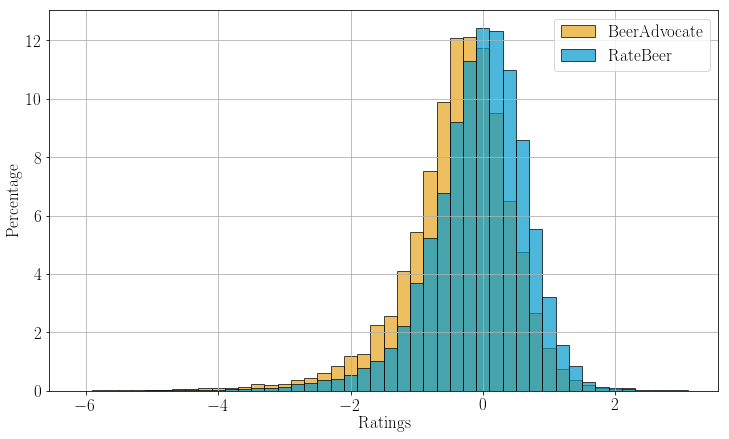

In [16]:
nbr_bins = 45

bin_edges = {'ba': None, 'rb': None}
hist = {'ba': None, 'rb': None}

for key in colors.keys():
    a, bin_edges[key] = np.histogram(zscore_avg[key], range=(-6, 3), bins=nbr_bins)
    hist[key], a = np.histogram(zscore_avg[key], range=(-6, 3), bins=nbr_bins+1)
    hist[key] = hist[key]/np.sum(hist[key])*100
    
plt.figure(figsize=(12,7))
plt.rc('font', family='serif')
plt.rc('font', size=17)

for key in hist.keys():
    width = bin_edges[key][1] - bin_edges[key][0]
    plt.bar(bin_edges[key], hist[key], width = width, facecolor=colors[key], edgecolor='k', alpha=0.7, label=labels[key])
    
plt.grid()
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Ratings')

plt.savefig(save_folder + 'avg_zscore_matched_beers.pdf', bbox_inches='tight')

# Boxplots

In [4]:
with open('../data/tmp/z_score_params_matched_ratings.json') as file:
    z_score_params = json.load(file)

zscore = {'ba': [], 'rb': []}
ratings = {'ba': [], 'rb': []}

for key in ratings.keys():
    print('Parsing {} reviews.'.format(key.upper()))
    
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    for item in gen:
        
        date = int(item['date'])
        year = str(datetime.fromtimestamp(date).year)
        
        rat = float(item['rating'])
                     
        ratings[key].append(rat)
        zscore[key].append((rat-z_score_params[key][year]['mean'])/z_score_params[key][year]['std'])

Parsing BA reviews.
Parsing RB reviews.


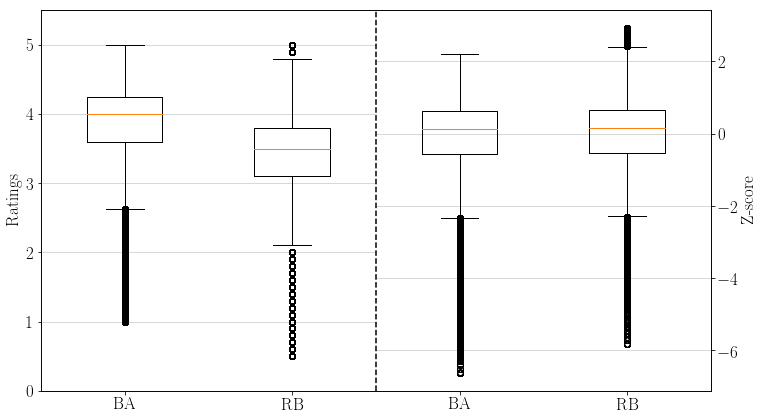

In [5]:
plt.figure(figsize=(12,7))
plt.rc('font', family='serif')
plt.rc('font', size=17)

fig, ax1 = plt.subplots(figsize=(12,7))

data_rat = [ratings['ba'], ratings['rb'], [], []]
data_z = [[], [], zscore['ba'], zscore['rb']]

for i in range(1, 6):
    ax1.plot([0.5, 2.5], [i, i], 'k', linewidth=0.5, alpha=0.3)

ax1.boxplot(data_rat, showmeans=False, meanline=True)
ax1.axis([0.5, 4.5, 0, 5.5])
ax1.plot([2.5, 2.5], [0, 5.5], 'k--')

ax1.set_ylabel('Ratings')

ax2 = ax1.twinx()
ax2.boxplot(data_z, showmeans=False, meanline=True)
ax2.set_ylabel('Z-score')

for i in range(-6, 4, 2):
    ax2.plot([2.5, 4.5], [i, i], 'k', linewidth=0.5, alpha=0.3)

plt.xticks([1, 2, 3, 4], ['BA', 'RB', 'BA', 'RB'])

plt.savefig(save_folder + 'zscore_versus_ratings.pdf', bbox_inches='tight')